In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

In [4]:
#load the data
airbnb = pd.read_csv('listings.csv')

In [5]:
#clean the price and convert it to float
airbnb['price'] = airbnb['price'].replace('[\$,]', '', regex=True).astype(float)

In [6]:
airbnb.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [10]:
# 3) Create price category for stratified sampling (price bins)
# Choose bins similar to how the book created income categories
airbnb['price_cat'] = pd.cut(airbnb['price'],
 bins=[-1, 50, 100, 200, 500, np.inf],
 labels=[1,2,3,4,5])

In [11]:
airbnb['price_cat'].value_counts()

price_cat
2    1611
3    1401
4     430
1     349
5      27
Name: count, dtype: int64

In [13]:
# 4) Stratified split using price_cat (like the book)
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score, GridSearchCV
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [14]:
for train_index, test_index in split.split(airbnb, airbnb['price_cat']):
 strat_train_set = airbnb.loc[train_index]
 strat_test_set = airbnb.loc[test_index]


In [15]:
# Remove the price_cat attribute so the data is back to normal
for set_ in (strat_train_set, strat_test_set):
 set_.drop('price_cat', axis=1, inplace=True)

In [16]:
# 5) Exploratory Data Analysis (EDA)
# Copy training set so we don't change the original
airbnb_explore = strat_train_set.copy()


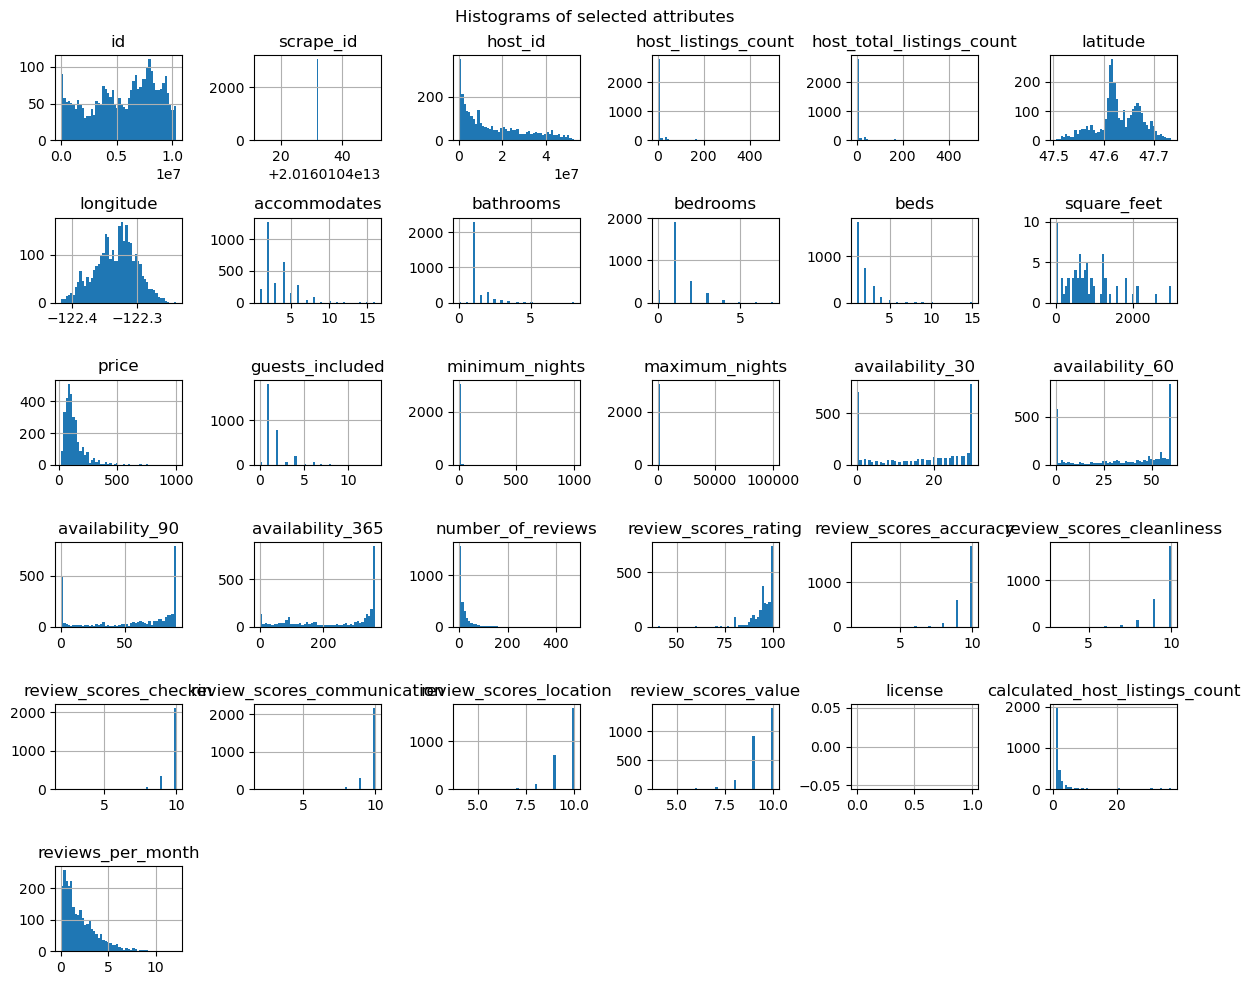

In [17]:
# Histograms (similar to the book)
airbnb_explore.hist(bins=50, figsize=(12,10))
plt.suptitle('Histograms of selected attributes')
plt.tight_layout()
plt.show()

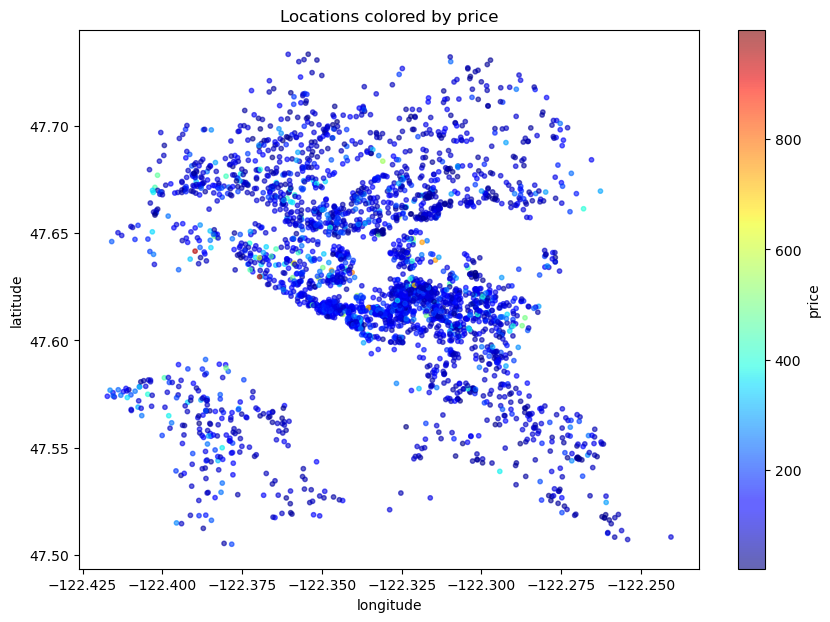

In [18]:
# Scatter plot of latitude vs longitude colored by price (like the book's map scatter)
plt.figure(figsize=(10,7))
plt.scatter(airbnb_explore['longitude'], airbnb_explore['latitude'], s=10,
 c=airbnb_explore['price'], cmap=plt.get_cmap('jet'), alpha=0.6)
plt.colorbar(label='price')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Locations colored by price')
plt.show()

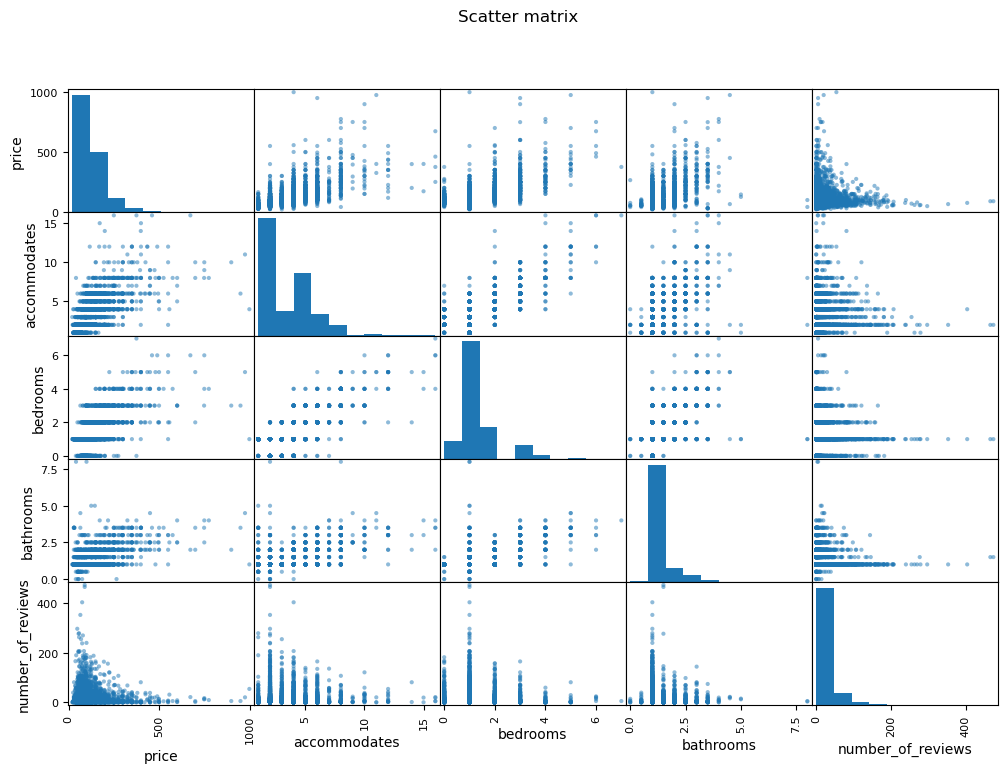

In [20]:
# Scatter matrix for a few attributes
attributes = ['price','accommodates','bedrooms','bathrooms','number_of_reviews']
scatter_matrix(airbnb_explore[attributes], figsize=(12,8))
plt.suptitle('Scatter matrix')
plt.show()

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

In [24]:
# 6) Create new attributes via a custom transformer (CombinedAttributesAdder)
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
     def __init__(self, add_price_per_bedroom=True):
         self.add_price_per_bedroom = add_price_per_bedroom
     def fit(self, X, y=None):
         return self
     def transform(self, X):
 # X is expected as numpy array with columns in this order:
 # ['accommodates','bedrooms','bathrooms','number_of_reviews','review_scores_rating','latitude','longitude']
         accommodates_ix, bedrooms_ix, bathrooms_ix, reviews_ix = 0, 1, 2, 3
         bedrooms = X[:, bedrooms_ix]
 # avoid division by zero
         bedrooms_safe = np.where(bedrooms == 0, 1, bedrooms)
         price_per_bedroom = X[:, -1] / bedrooms_safe if X.shape[1] >= 8 else np.zeros((X.shape[0],))
         if self.add_price_per_bedroom:
             return np.c_[X, price_per_bedroom]
         else:
             return X

In [26]:
# 7) Prepare pipelines (numerical and categorical)
num_attribs = ['accommodates','bedrooms','bathrooms','number_of_reviews','review_scores_rating','latitude','longitude']
cat_attribs = ['neighbourhood']


In [27]:
# The CombinedAttributesAdder defined above expects numeric arrays; we'll add it in the numeric pipeline
from sklearn.preprocessing import FunctionTransformer

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [51]:
num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy='median')),
 ('attribs_adder', CombinedAttributesAdder(add_price_per_bedroom=False)), # set False because price is not presen ('std_scaler', StandardScaler()),
])

In [52]:
full_pipeline = ColumnTransformer([
 ('num', num_pipeline, num_attribs),
 ('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs),
])


In [53]:
# 8) Prepare the data
airbnb = strat_train_set.drop('price', axis=1)
airbnb_labels = strat_train_set['price'].copy()


In [54]:
airbnb_prepared = full_pipeline.fit_transform(airbnb)
print('Prepared data shape:', airbnb_prepared.shape)


Prepared data shape: (3054, 89)


In [55]:
from sklearn.linear_model import LinearRegression

In [56]:
# 9) Train models (Linear Regression, Decision Tree, Random Forest) — same flow as the book
lin_reg = LinearRegression()
lin_reg.fit(airbnb_prepared, airbnb_labels)

LinearRegression()

In [57]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(airbnb_prepared, airbnb_labels)

DecisionTreeRegressor(random_state=42)

In [58]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(airbnb_prepared, airbnb_labels)


RandomForestRegressor(random_state=42)

In [59]:
# 10) Evaluate on training set (quick test) — the book checks on some instances
some_data = airbnb.iloc[:5]
some_labels = airbnb_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:', lin_reg.predict(some_data_prepared))
print('Labels:', list(some_labels))

Predictions: [216.87462999 143.20804157 116.14125237 111.17351744  91.41685818]
Labels: [399.0, 126.0, 200.0, 89.0, 84.0]


C:\Users\sthut\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [60]:
from sklearn.model_selection import cross_val_score
def display_scores(scores):
 print('Scores:', scores)
 print('Mean:', scores.mean())
 print('Std:', scores.std())


In [61]:
# Linear Regression CV
lin_scores = cross_val_score(lin_reg, airbnb_prepared, airbnb_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print('\nLinear Regression CV:')
display_scores(lin_rmse_scores)



Linear Regression CV:
Scores: [58.61100988 62.43658127 60.35722294 69.76374256 55.87649803 48.07002864
 74.20300934 57.88692984 60.18330883 61.42244378]
Mean: 60.88107751140086
Std: 6.80541326129124


In [62]:
tree_scores = cross_val_score(tree_reg, airbnb_prepared, airbnb_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
print('\nDecision Tree CV:')
display_scores(tree_rmse_scores)


Decision Tree CV:
Scores: [73.99505371 75.47210886 73.55579004 84.16071616 63.7508727  67.82409746
 88.92527716 75.78898661 72.56404746 77.40913235]
Mean: 75.3446082511278
Std: 6.8582781198180784


In [63]:
# Random Forest CV
forest_scores = cross_val_score(forest_reg, airbnb_prepared, airbnb_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print('\nRandom Forest CV:')
display_scores(forest_rmse_scores)


Random Forest CV:
Scores: [58.92117695 55.44094294 58.51621826 67.40085457 53.80657978 47.33552474
 70.69704402 55.215328   58.08214249 56.84798748]
Mean: 58.226379922044714
Std: 6.3019554117768894


In [64]:
# 12) Grid Search for Random Forest (same pattern as book)
param_grid = [
 {'n_estimators': [50, 100], 'max_features': [4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [30, 50], 'max_features': [4, 6]},
]


In [65]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
 return_train_score=True, n_jobs=-1)
grid_search.fit(airbnb_prepared, airbnb_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [4, 6, 8], 'n_estimators': [50, 100]},
                         {'bootstrap': [False], 'max_features': [4, 6],
                          'n_estimators': [30, 50]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [67]:
print('Best params:', grid_search.best_params_)
print('Best estimator:', grid_search.best_estimator_)

Best params: {'max_features': 6, 'n_estimators': 100}
Best estimator: RandomForestRegressor(max_features=6, random_state=42)


In [68]:
# 13) Evaluate the final model on the test set (as the book does)
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('price', axis=1)
y_test = strat_test_set['price'].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print('Final RMSE on test set:', final_rmse)

Final RMSE on test set: 63.38489744224421


C:\Users\sthut\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [69]:
# 14) Feature importance inspection (like the book)
if hasattr(final_model, 'feature_importances_'):
 importances = final_model.feature_importances_
 # Note: due to OneHotEncoder, feature names mapping requires more work; here we print top importances
 print('Top feature importances (first 20) :', importances[:20])

Top feature importances (first 20) : [2.04672536e-01 1.68359560e-01 1.50791153e-01 7.28002442e-02
 5.22237671e-02 1.07026086e-01 1.08092205e-01 2.21168896e-03
 9.30459155e-05 9.39488588e-04 2.94650810e-03 9.14606137e-03
 6.09214875e-04 5.17487800e-05 6.53504284e-04 1.55487783e-04
 5.70596020e-04 5.57256860e-03 1.93729590e-04 4.55725551e-03]


In [70]:
# 15) Save the notebook code / models if desired
# Example: save the grid search and pipeline using joblib
import joblib
joblib.dump(final_model, 'final_airbnb_model.pkl')
joblib.dump(full_pipeline, 'airbnb_preprocessing_pipeline.pkl')
print('Saved final_model and preprocessing pipeline to disk.')

Saved final_model and preprocessing pipeline to disk.
